In [ ]:
import utils
import time
import os
import matplotlib.pyplot as plt
import librosa, librosa.display
import numpy as np

In [ ]:
tracks = utils.load_csv("tracks")
train_tracks = tracks[tracks["set", "split"] == "training"]
validate_tracks = tracks[tracks["set", "split"] == "validation"]
test_tracks = tracks[tracks["set", "split"] == "test"]
del tracks

In [ ]:
sr = 22050

### Random Sample

In [8]:
random_sample = train_tracks.sample()
sample_id = random_sample.index[0]
sample_genre = random_sample["track", "genre_top"].item()
sample_waveform, sr = utils.load_waveform(sample_id, sr=sr)
print(f"Track ID: {sample_id}, Genre: {sample_genre}")

Track ID: 126357, Genre: Pop


#### CQT

Shape of CQT: (84, 647), Shape of dB CQT: (84, 647)


Text(0.5, 1.0, 'dB CQT')

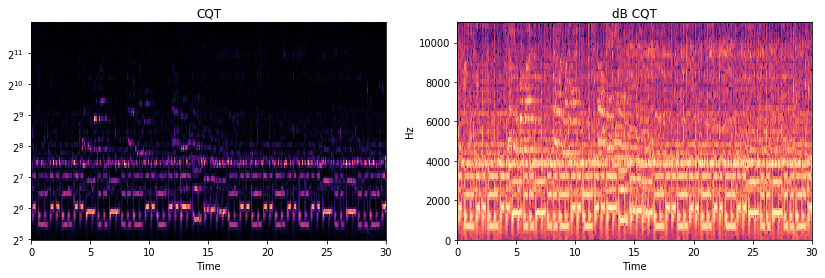

In [9]:
sample_cqt = np.abs(librosa.cqt(sample_waveform, sr=sr, hop_length=1024, bins_per_octave=12, n_bins=7*12))
dB_cqt = librosa.amplitude_to_db(sample_cqt, ref=np.max)
print(f"Shape of CQT: {sample_cqt.shape}, Shape of dB CQT: {dB_cqt.shape}")

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(sample_cqt, y_axis="cqt", x_axis="time", sr=sr, hop_length=1024)
plt.title("CQT")
plt.subplot(1, 2, 2)
librosa.display.specshow(dB_cqt, y_axis="linear", x_axis="time", sr=sr, hop_length=1024)
plt.title("dB CQT")

#### Chroma CQT and CENS

Shape of Chroma CQT: (12, 647), Chroma CENS: (12, 647)


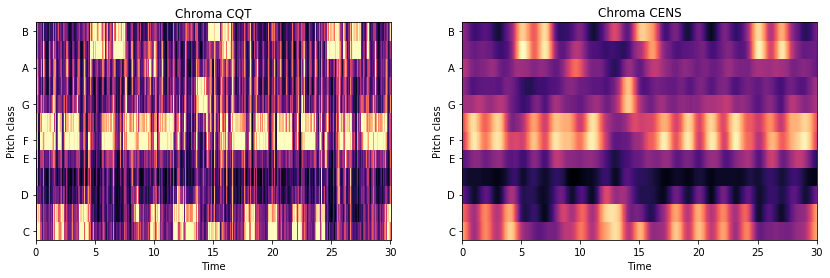

In [10]:
chroma_cqt = librosa.feature.chroma_cqt(C=sample_cqt, hop_length=1024)
chroma_cens = librosa.feature.chroma_cens(C=sample_cqt, hop_length=1024, sr=sr)
print(f"Shape of Chroma CQT: {chroma_cqt.shape}, Chroma CENS: {chroma_cens.shape}")

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(chroma_cqt, sr=sr, hop_length=1024, y_axis="chroma", x_axis="time")
plt.title("Chroma CQT")
plt.subplot(1, 2, 2)
plt.title("Chroma CENS")
librosa.display.specshow(chroma_cens, sr=sr, hop_length=1024, y_axis="chroma", x_axis="time")

#### Linear and Mel scale STFT

Shape of Linear STFT: (513, 647), Mel STFT: (128, 647)


Text(0.5, 1.0, 'Mel STFT')

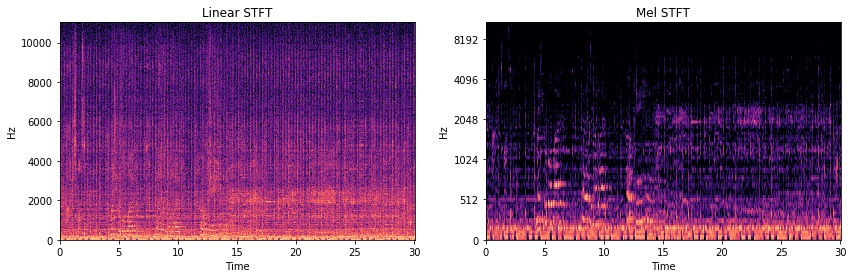

In [11]:
stft_linear = np.abs(librosa.stft(sample_waveform, n_fft=1024, hop_length=1024))
stft_linear_db = librosa.amplitude_to_db(stft_linear, ref=np.max)
stft_mel = librosa.feature.melspectrogram(S=stft_linear**2, n_fft=1024, hop_length=1024)
stft_mel_db = librosa.amplitude_to_db(stft_mel, ref=np.max)

print(f"Shape of Linear STFT: {stft_linear_db.shape}, Mel STFT: {stft_mel_db.shape}")

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_linear_db, x_axis="time", y_axis="linear", sr=sr, hop_length=1024)
plt.title("Linear STFT")
plt.subplot(1, 2, 2)
librosa.display.specshow(stft_mel_db, x_axis="time", y_axis="mel", sr=sr, hop_length=1024)
plt.title("Mel STFT")

#### Chroma STFT

Shape of Chroma STFT: (12, 647)


Text(0.5, 1.0, 'Chroma STFT')

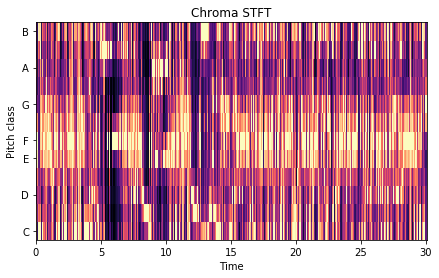

In [12]:
chroma_stft = librosa.feature.chroma_stft(S=stft_linear**2, hop_length=1024, n_fft=1024, n_chroma=12)
print(f"Shape of Chroma STFT: {chroma_stft.shape}")

plt.figure(figsize=(7, 4))
librosa.display.specshow(chroma_stft, y_axis="chroma", x_axis="time", sr=sr, hop_length=1024)
plt.title("Chroma STFT")

### Create directory to store features

In [ ]:
if not os.path.isdir("data/features"):
    os.makedirs("data/features")

if not os.path.isdir("data/features/ids"):
    os.makedirs("data/features/ids")

if not os.path.isdir("data/features/cqt"):
    os.makedirs("data/features/cqt")

if not os.path.isdir("data/features/db_cqt"):
    os.makedirs("data/features/db_cqt")

if not os.path.isdir("data/features/chroma_cqt"):
    os.makedirs("data/features/chroma_cqt")
    
if not os.path.isdir("data/features/chroma_cens"):
    os.makedirs("data/features/chroma_cens")

if not os.path.isdir("data/features/stft"):
    os.makedirs("data/features/stft")

if not os.path.isdir("data/features/linear_stft"):
    os.makedirs("data/features/linear_stft")

if not os.path.isdir("data/features/mel_stft/"):
    os.makedirs("data/features/mel_stft/")

if not os.path.isdir("data/features/chroma_stft"):
    os.makedirs("data/features/chroma_stft")

### Create CQTs for each track

In [ ]:
test_ids, test_cqts, test_failed_ids = utils.create_feature_array(test_tracks, "cqt")
np.save("data/features/cqt/test_cqt.npy", test_cqts)
np.save("data/features/ids/test_ids.npy", test_ids)
np.save("data/features/ids/test_failed_ids.npy", test_failed_ids)

In [ ]:
validate_ids, validate_cqts, validate_failed_ids = utils.create_feature_array(validate_tracks, "cqt")
np.save("data/features/cqt/validate_cqt.npy", validate_cqts)
np.save("data/features/ids/validate_ids.npy", validate_ids)
np.save("data/features/ids/validate_failed_ids.npy", validate_failed_ids)

In [ ]:
n_chunks = 8
chunk_len = int(train_tracks.shape[0] / n_chunks)

for chunk_i in range(n_chunks):
    start_i = chunk_len * chunk_i
    end_i = chunk_len * (chunk_i + 1) if chunk_i != (n_chunks - 1) else train_tracks.shape[0]
    chunk = train_tracks.iloc[start_i:end_i]
    train_ids, train_cqts, train_failed_ids = utils.create_feature_array(chunk, "cqt")
    np.save(f"data/features/cqt/train_cqt_{chunk_i}.npy", train_cqts)
    np.save(f"data/features/ids/train_ids_{chunk_i}.npy", train_ids)
    np.save(f"data/features/ids/train_failed_ids_{chunk_i}.npy", train_failed_ids)

In [ ]:
def create_dB_cqt(cqt_arr):
    print("Processing...")
    dB_cqts = np.empty((0, 84, 640))
    count = 0
    start = time.time()
    for cqt in cqt_arr:
        count += 1
        if count % 100 == 0:
            print(f"{utils.time_since(start)}, Processing {count} out of {cqt_arr.shape[0]}")
        
        dB_cqt = librosa.amplitude_to_db(cqt, ref=np.max)
        dB_cqts = np.append(dB_cqts, [dB_cqt], axis=0)
        del dB_cqt
    
    return dB_cqts

In [ ]:
test_cqts = np.load("data/features/cqt/test_cqt.npy")
test_db_cqts = create_dB_cqt(test_cqts)
np.save("data/features/db_cqt/test_db_cqt.npy", test_db_cqts)

In [ ]:
validate_cqts = np.load("data/features/cqt/validate_cqt.npy")
validate_db_cqts = create_dB_cqt(validate_cqts)
np.save("data/features/db_cqt/validate_db_cqt.npy", validate_db_cqts)

In [ ]:
n_chunks = 8

for i in range(n_chunks):
    print(f"processing chunk {i}")
    train_cqts = np.load(f"data/features/cqt/train_cqt_{i}.npy")
    train_db_cqts = create_dB_cqt(train_cqts)
    np.save(f"data/features/db_cqt/train_db_cqt_{i}.npy", train_db_cqts)

### Create Chroma CQT and CENS for each track

In [ ]:
def create_chroma_from_cqt(cqts_arr, type):
    print(f"Processing chroma_{type}")
    chromas = np.empty((0, 12, 640))
    count = 0
    start = time.time()
    for cqt in cqts_arr:
        count += 1
        if count % 100 == 0:
            print(f"{utils.time_since(start)}, Processing {count} out of {cqts_arr.shape[0]}")

        if type == "cqt":
            chroma = librosa.feature.chroma_cqt(C=cqt)
        elif type == "cens":
            chroma = librosa.feature.chroma_cens(C=cqt)
        chromas = np.append(chromas, [chroma], axis=0)

    return chromas

In [ ]:
test_cqts = np.load("data/features/cqt/test_cqt.npy")
test_chroma_cqts = create_chroma_from_cqt(test_cqts, "cqt")
test_chroma_cens = create_chroma_from_cqt(test_cqts, "cens")
np.save("data/features/chroma_cqt/test_chroma_cqt.npy", test_chroma_cqts)
np.save("data/features/chroma_cens/test_chroma_cens.npy", test_chroma_cens)
    

In [ ]:
validate_cqts = np.load("data/features/cqt/validate_cqt.npy")
validate_chroma_cqts = create_chroma_from_cqt(validate_cqts, "cqt")
validate_chroma_cens = create_chroma_from_cqt(validate_cqts, "cens")
np.save("data/features/chroma_cqt/validate_chroma_cqt.npy", validate_chroma_cqts)
np.save("data/features/chroma_cens/validate_chroma_cens.npy", validate_chroma_cens)
    

In [ ]:
n_chunks = 8

for i in range(n_chunks):
    print(f"Processing chunk {i}")
    train_cqts = np.load(f"data/features/cqt/train_cqt_{i}.npy")
    train_chroma_cqts = create_chroma_from_cqt(train_cqts, "cqt")
    train_chroma_cens = create_chroma_from_cqt(train_cqts, "cens")
    np.save(f"data/features/chroma_cqt/train_chroma_cqt_{i}.npy", train_chroma_cqts)
    np.save(f"data/features/chroma_cens/train_chroma_cens_{i}.npy", train_chroma_cens)

### Create STFT

In [ ]:
test_ids, test_stfts, test_failed_ids = utils.create_feature_array(test_tracks, "stft")
np.save("data/features/stft/test_stft.npy", test_stfts)

In [ ]:
validate_ids, validate_stfts, validate_failed_ids = utils.create_feature_array(validate_tracks, "stft")
np.save("data/features/stft/validate_stft.npy", validate_stfts)

In [ ]:
n_chunks = 8
chunk_len = int(train_tracks.shape[0] / n_chunks)

for chunk_i in range(7, n_chunks):
    start_i = chunk_len * chunk_i
    end_i = chunk_len * (chunk_i + 1) if chunk_i != (n_chunks - 1) else train_tracks.shape[0]
    chunk = train_tracks.iloc[start_i:end_i]
    _, train_stfts, _ = utils.create_feature_array(chunk, "stft")
    np.save(f"data/features/stft/train_stft_{chunk_i}.npy", train_stfts)
    del train_stfts

### Create Linear and Mel Scale STFT in dB, and Chroma STFT
* It has breaks the STFT into chunks in order for this to run using only 8GB of memory, since the STFTs are big

In [ ]:
def create_from_stft(stfts, type):
    type_size = {"linear": (513, 640), "mel": (128, 640), "chroma": (12, 640)}
    feature_arr = np.empty((0, type_size[type][0], type_size[type][1]))

    count = 0
    start = time.time()
    for stft in stfts:
        count += 1
        if count % 100 == 0:
            print(f"{utils.time_since(start)}, Processing {count} out of {stfts.shape[0]}")
    
        if type == "linear":
            feature = librosa.amplitude_to_db(stft, ref=np.max)
        elif type == "mel":
            feature = librosa.feature.melspectrogram(S=stft**2, n_fft=1024, hop_length=1024)
        elif type == "chroma":
            feature = librosa.feature.chroma_stft(S=stft**2, n_fft=1024, hop_length=1024, n_chroma=12)
        feature_arr = np.append(feature_arr, [feature], axis=0)
        del feature
    
    return feature_arr

In [ ]:
test_stfts = np.load("data/features/stft/test_stft.npy")

for i in range(8):
    print(f"Creating chunk {i}...")
    chunk_stfts = test_stfts[i*100:(i + 1)*100]
    np.save(f"data/features/linear_stft/test_linear_stft_{i}.npy", create_from_stft(chunk_stfts, "linear"))
    np.save(f"data/features/mel_stft/test_mel_stft_{i}.npy", create_from_stft(chunk_stfts, "mel"))
    np.save(f"data/features/chroma_stft/test_chroma_stft_{i}.npy", create_from_stft(chunk_stfts, "chroma"))
    del chunk_stfts

del test_stfts

for type in ["linear", "mel", "chroma"]:
    type_size = {"linear": (513, 640), "mel": (128, 640), "chroma": (12, 640)}
    feature_arr = np.empty((0, type_size[type][0], type_size[type][1]))
    for i in range(8):
        print(f"Getting chunk {i} for {type} STFT")
        feature_arr = np.append(feature_arr, np.load(f"data/features/{type}_stft/test_{type}_stft_{i}.npy"), axis=0)
        os.remove(f"data/features/{type}_stft/test_{type}_stft_{i}.npy")
    np.save(f"data/features/{type}_stft/test_{type}_stft.npy", feature_arr)
    del feature_arr

os.remove("data/features/stft/test_stft.npy")


In [ ]:
validate_stfts = np.load("data/features/stft/validate_stft.npy")

for i in range(8):
    print(f"Creating chunk {i}...")
    chunk_stfts = validate_stfts[i*100:(i + 1)*100]
    np.save(f"data/features/linear_stft/validate_linear_stft_{i}.npy", create_from_stft(chunk_stfts, "linear"))
    np.save(f"data/features/mel_stft/validate_mel_stft_{i}.npy", create_from_stft(chunk_stfts, "mel"))
    np.save(f"data/features/chroma_stft/validate_chroma_stft_{i}.npy", create_from_stft(chunk_stfts, "chroma"))
    del chunk_stfts

del validate_stfts

for type in ["linear", "mel", "chroma"]:
    type_size = {"linear": (513, 640), "mel": (128, 640), "chroma": (12, 640)}
    feature_arr = np.empty((0, type_size[type][0], type_size[type][1]))
    for i in range(8):
        print(f"Getting chunk {i} for {type} STFT")
        feature_arr = np.append(feature_arr, np.load(f"data/features/{type}_stft/validate_{type}_stft_{i}.npy"), axis=0)
        os.remove(f"data/features/{type}_stft/validate_{type}_stft_{i}.npy")
    np.save(f"data/features/{type}_stft/validate_{type}_stft.npy", feature_arr)
    del feature_arr

os.remove("data/features/stft/validate_stft.npy")


In [ ]:
n_chunks = 8

for chunk in range(n_chunks):
    print(f"Processing large training chunk {chunk}")
    train_stfts = np.load(f"data/features/stft/train_stft_{chunk}.npy")

    for i in range(8):
        print(f"Creating chunk {i}...")
        chunk_stfts = train_stfts[i*100:(i + 1)*100]
        np.save(f"data/features/linear_stft/train_linear_stft_{chunk}_{i}.npy", create_from_stft(chunk_stfts, "linear"))
        np.save(f"data/features/mel_stft/train_mel_stft_{chunk}_{i}.npy", create_from_stft(chunk_stfts, "mel"))
        np.save(f"data/features/chroma_stft/train_chroma_stft_{chunk}_{i}.npy", create_from_stft(chunk_stfts, "chroma"))
        del chunk_stfts

    del train_stfts

    for type in ["linear", "mel", "chroma"]:
        type_size = {"linear": (513, 640), "mel": (128, 640), "chroma": (12, 640)}
        feature_arr = np.empty((0, type_size[type][0], type_size[type][1]))
        for i in range(8):
            print(f"Getting chunk {i} for {type} STFT")
            feature_arr = np.append(feature_arr, np.load(f"data/features/{type}_stft/train_{type}_stft_{chunk}_{i}.npy"), axis=0)
            os.remove(f"data/features/{type}_stft/train_{type}_stft_{chunk}_{i}.npy")
        np.save(f"data/features/{type}_stft/train_{type}_stft_{chunk}.npy", feature_arr)
        del feature_arr

    os.remove(f"data/features/stft/train_stft_{chunk}.npy")